In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion

from gammapy.irf import load_cta_irfs
from gammapy.makers import SpectrumDatasetMaker
from gammapy.data import Observation
from gammapy.estimators import SensitivityEstimator
from gammapy.datasets import SpectrumDataset, SpectrumDatasetOnOff
from gammapy.maps import MapAxis
from gammapy.irf import EffectiveAreaTable2D, load_cta_irfs, Background2D,EnergyDependentMultiGaussPSF,EnergyDispersion2D, Background3D

In [3]:
center = SkyCoord("0 deg", "0.5 deg")
region = CircleSkyRegion(center=center, radius=0.1 * u.deg)

e_reco = MapAxis.from_energy_bounds("0.03 TeV", "30 TeV", nbin=20)
e_true = MapAxis.from_energy_bounds(
    "0.01 TeV", "100 TeV", nbin=100, name="energy_true"
)

empty_dataset = SpectrumDataset.create(
    e_reco=e_reco, e_true=e_true, region=region
)


In [4]:
def load_cta_irfs(filename):

    aeff = EffectiveAreaTable2D.read(filename, hdu="EFFECTIVE AREA")
    bkg = Background3D.read(filename, hdu="BACKGROUND")
    edisp = EnergyDispersion2D.read(filename, hdu="ENERGY DISPERSION")
    psf = EnergyDependentMultiGaussPSF.read(filename, hdu="POINT SPREAD FUNCTION")

    return dict(aeff=aeff, bkg=bkg, edisp=edisp, psf=psf)

In [5]:
irfs = load_cta_irfs("../data/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz")

In [6]:
pointing = SkyCoord("0 deg", "0 deg")
obs = Observation.create(pointing=pointing, irfs=irfs, livetime="50 h")

In [7]:
spectrum_maker = SpectrumDatasetMaker(
    selection=["exposure", "edisp", "background"]
)
dataset = spectrum_maker.run(empty_dataset, obs)

In [8]:
containment = 0.68

# correct exposure
dataset.exposure *= containment

# correct background estimation
on_radii = obs.psf.containment_radius(
    energy=e_reco.center, theta=0.5 * u.deg, fraction=containment
)[0]
factor = (1 - np.cos(on_radii)) / (1 - np.cos(region.radius))
dataset.background *= factor.value.reshape((-1, 1, 1))



In [9]:
dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=dataset, acceptance=1, acceptance_off=5
)

In [10]:
sensitivity_estimator = SensitivityEstimator(
    gamma_min=5, n_sigma=3, bkg_syst_fraction=0.10
)
sensitivity_table = sensitivity_estimator.run(dataset_on_off)

In [11]:
sensitivity_table

energy,e2dnde,excess,background,criterion
TeV,erg / (cm2 s),,,
float64,float64,float64,float64,bytes12
0.0356551,5.08783e-11,299.189,2991.89,bkg
0.0503641,1.18033e-11,1021.44,10214.4,bkg
0.0711412,3.43066e-12,1397.59,13975.9,bkg
0.10049,1.7484e-12,835.174,8351.74,bkg
0.141945,8.55119e-13,319.552,3195.52,bkg
0.200503,3.742e-13,108.993,1058.07,significance
0.283218,2.51134e-13,66.5612,384.844,significance
0.400056,1.90521e-13,43.4196,158.179,significance


In [12]:
sensitivity_table

energy,e2dnde,excess,background,criterion
TeV,erg / (cm2 s),,,
float64,float64,float64,float64,bytes12
0.0356551,5.08783e-11,299.189,2991.89,bkg
0.0503641,1.18033e-11,1021.44,10214.4,bkg
0.0711412,3.43066e-12,1397.59,13975.9,bkg
0.10049,1.7484e-12,835.174,8351.74,bkg
0.141945,8.55119e-13,319.552,3195.52,bkg
0.200503,3.742e-13,108.993,1058.07,significance
0.283218,2.51134e-13,66.5612,384.844,significance
0.400056,1.90521e-13,43.4196,158.179,significance


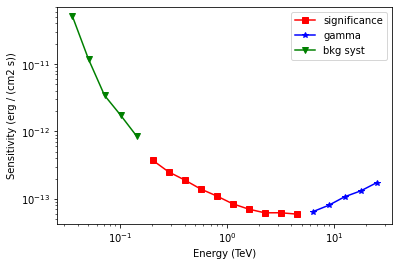

In [13]:
# Plot the sensitivity curve
t = sensitivity_table

is_s = t["criterion"] == "significance"
plt.plot(
    t["energy"][is_s],
    t["e2dnde"][is_s],
    "s-",
    color="red",
    label="significance",
)

is_g = t["criterion"] == "gamma"
plt.plot(
    t["energy"][is_g], t["e2dnde"][is_g], "*-", color="blue", label="gamma"
)
is_bkg_syst = t["criterion"] == "bkg"
plt.plot(
    t["energy"][is_bkg_syst],
    t["e2dnde"][is_bkg_syst],
    "v-",
    color="green",
    label="bkg syst",
)

plt.loglog()
plt.xlabel(f"Energy ({t['energy'].unit})")
plt.ylabel(f"Sensitivity ({t['e2dnde'].unit})")
plt.legend();

(0.01, 0.5)

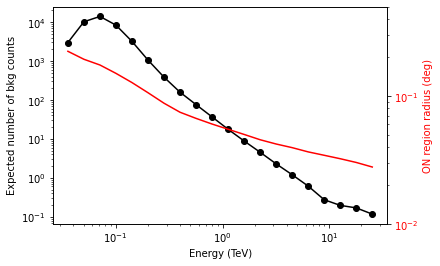

In [14]:
# Plot expected number of counts for signal and background
fig, ax1 = plt.subplots()
# ax1.plot( t["energy"], t["excess"],"o-", color="red", label="signal")
ax1.plot(
    t["energy"], t["background"], "o-", color="black", label="blackground"
)

ax1.loglog()
ax1.set_xlabel(f"Energy ({t['energy'].unit})")
ax1.set_ylabel("Expected number of bkg counts")

ax2 = ax1.twinx()
ax2.set_ylabel(f"ON region radius ({on_radii.unit})", color="red")
ax2.semilogy(t["energy"], on_radii, color="red", label="PSF68")
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(0.01, 0.5)